## Social Media Group Assignment 1                                  
###### - Anurag, Apoorva, Jui, Avani, Vincent
### Q1: Logistic Regression

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import os 
from sklearn.preprocessing import StandardScaler


In [2]:
train =  pd.read_csv('predict-who-is-more-influential-in-a-social-network/train.csv')
test = pd.read_csv('predict-who-is-more-influential-in-a-social-network/test.csv')
print("Does train data contain NaN?  %s"% train.isnull().any().any())
print("Does test data contain NaN?  %s"% test.isnull().any().any())

Does train data contain NaN?  False
Does test data contain NaN?  False


### Preprocessing

In Question 2, we will have to evaluate the feature importance based on this model. Accordingly, we scale and center each feature before modeling. 

The data includes information for both person A and B. We subtract the columns for A by the same columns for B. 
Take "followers" for example: the larger the number is, the more followers person A has compared to person B. 
This manipulation makes sense since our prediction goal is "whether A follows B ( i.e. B is an influencer to A), so we feed the model with individual information of A and B, but the relative number of A against B. 

Here we also include an additional feature: the sum of feature_1 to feature_3. We will determine whether include the feature sum or individual feature based on validation_set accuracy and correlation matrix later. 

In [3]:
#scale and center the data
scaler = StandardScaler()
train_y = train.iloc[:,:1]
train_x = train.iloc[:,1:]
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns = train_x.columns)


train_x_div = DataFrame()
for i in range(0,11):
    train_x_div = pd.concat([train_x_div,DataFrame(train_x.iloc[:,i]-train_x.iloc[:,i+11], columns=[train_x.columns.values[i]])],\
         axis = 1)
    
#check integrity: any nan generated?
for i in range(0,11):
    if(train_x_div.isnull().any().iloc[i]):
        print(sum(train_x_div.isnull().iloc[:,i]))

#check integrity: any inf generated?
train_x_div = train_x_div.mask(np.isinf(train_x_div))

#drop inf and nan. In this case, the dropped dataframe still has 5500 rows. No nan/inf is generated here. 
temp = pd.concat([train_y, train_x_div], axis = 1)
temp.dropna(how = "any", inplace = True)


train_y = temp.iloc[:,:1].reset_index(inplace = False, drop = True)
train_x_div = temp.iloc[:,1:].reset_index(inplace = False, drop = True)

#Create a new feature: the sum of 3 features.
train_x_div["feature_sum"] = train_x_div['A_network_feature_1']+train_x_div['A_network_feature_2']+train_x_div['A_network_feature_3']

#train_y and train_x_div is the data for modeling. 

### Correlations

Correlation can inflates confience interval of coefficients, making difficulties for identifying variable importance.
Since feature_1 is highly correlated to many other columns, we use "feature_sum" for modeling instead. (and will also use "feature_sum" for the scoring in question_2) The validation accuracy is almost the same in both cases.

Also, follower count is excluded due to the high correlation with listed_count and insignificant p-value when we included it. This improves accuracy slightly. 

Lastly, mention_received and retweet_received are excluded due to high correlation. The validation accuracy is almost indiffernet with/without these features. 

In [12]:
corr_A = np.corrcoef(train_x_div, rowvar=0)

corr_pair = []
thres = 0.6
for i in range(0,11):
    for j in range(0,11):
        if (j<i):
            continue
        if(corr_A[i][j] >thres and i!=j):
            corr_pair.append((i,j, corr_A[i][j]))
for pair in corr_pair:
    print("Corr of %s & %s: %.2f"%(train_x.columns.values[pair[0]], train_x.columns.values[pair[1]], pair[2]))

Corr of A_follower_count & A_listed_count: 0.79
Corr of A_listed_count & A_mentions_received: 0.68
Corr of A_listed_count & A_retweets_received: 0.69
Corr of A_listed_count & A_network_feature_1: 0.65
Corr of A_mentions_received & A_retweets_received: 0.99
Corr of A_mentions_received & A_network_feature_1: 0.91
Corr of A_retweets_received & A_network_feature_1: 0.92


### Model, Accuracy, Confusion Matrix and Important Features

In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [14]:
#Drop the features mentioned above, and do modeling
#Hold-out 500 observations as test data (we cannot use test_set on Kaggle. That won't provide confusion matrix)
x_in = train_x_div.drop(['A_follower_count','A_retweets_received','A_mentions_received','A_network_feature_1','A_network_feature_2','A_network_feature_3'],axis = 1).iloc[:5000,:]
y_in = train_y.iloc[:5000,:]
clf = LogisticRegressionCV(random_state=99, penalty='l2', cv = 10).fit(x_in, y_in)

#test data: accuracy and confusion matrix
pred = clf.predict(train_x_div.drop(['A_follower_count','A_retweets_received','A_mentions_received','A_network_feature_1','A_network_feature_2','A_network_feature_3'],axis = 1).iloc[5000:5501,:])
true = train_y.iloc[5000:5501,0].values
print("accuracy: %.2f"%accuracy_score(true,pred))
print("\nConfusion matrix:")
print(confusion_matrix(true,pred))

tn, fp, fn, tp = confusion_matrix(true, pred).ravel()

/Users/k.vincent/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.72

Confusion matrix:
[[173  82]
 [ 57 188]]


In [15]:
# test p-values
p_val = logit_pvalue(clf, x_in)

print('intercept', end = ':   ')
print("p-val: %.2f"%p_val[0], end = "      ")
print("coef_: %.2f"%clf.intercept_, end = "\n")
for i in range(0, len(logit_pvalue(clf, x_in))-1):
    print(x_in.columns.values[i], end = ":   ")
    print("p-val: %.2f"%p_val[i+1], end = "      ")
    print("coef_: %.2f"%clf.coef_[0][i], end = "\n")

intercept:   p-val: 0.11      coef_: 0.05
A_following_count:   p-val: 0.08      coef_: 0.05
A_listed_count:   p-val: 0.00      coef_: 1.31
A_mentions_sent:   p-val: 0.01      coef_: 0.09
A_retweets_sent:   p-val: 0.00      coef_: 0.23
A_posts:   p-val: 0.11      coef_: 0.05
feature_sum:   p-val: 0.00      coef_: 0.12


The outcome suggests that following count is not significant predictor under significant level of 0.05. Listed count, number of reweets sent and the sum of features are, respectively, top 3 features affecting the predicted probability of whether A influences B. 

## Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
x_in = train_x_div.drop(['A_follower_count','A_retweets_received','A_mentions_received','A_network_feature_1','A_network_feature_2','A_network_feature_3'],axis = 1).iloc[:5000,:]
y_in = train_y.iloc[:5000,:]
clf_rf.fit(x_in,y_in)

C:\Users\Anuraag\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

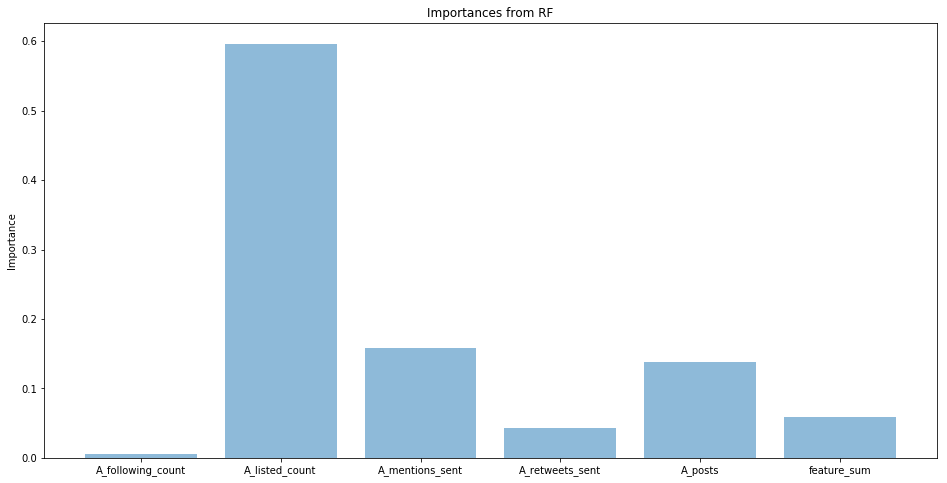

In [7]:
# PLotting Feature Importances
import matplotlib.pyplot as plt
objects = list(x_in.columns)
y_pos = np.arange(len(objects))
performance = clf_rf.feature_importances_

plt.figure(figsize=(16,8))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Importance')
plt.title('Importances from RF')
 
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
#test data: accuracy and confusion matrix
pred = clf_rf.predict(train_x_div.drop(['A_follower_count','A_retweets_received','A_mentions_received','A_network_feature_1','A_network_feature_2','A_network_feature_3'],axis = 1).iloc[5000:5501,:])
true = train_y.iloc[5000:5501,0].values
print("accuracy: %.2f"%accuracy_score(true,pred))
print("\nConfusion matrix:")
print(confusion_matrix(true,pred))

tn, fp, fn, tp = confusion_matrix(true, pred).ravel()

accuracy: 0.77

Confusion matrix:
[[201  54]
 [ 61 184]]


## Net Profit (for 500 rows of holdout data) (Random Forest model)

In [12]:
# Without Analytical Model
revenue = 0
for i in range(5000,len(train_y)):
    if train_y['Choice'][i] == 0:
        r = 0.0001 * train.iloc[i,12] * 10
    else:
        r = 0.0001 * train.iloc[i,1] * 10
    revenue = revenue + r
profit = revenue - 500 * 10    
profit

505761.25800000003

In [10]:
# With Analytics
pred_all = clf_rf.predict(train_x_div.drop(['A_follower_count','A_retweets_received','A_mentions_received','A_network_feature_1','A_network_feature_2','A_network_feature_3'],axis = 1))

revenue_2 = 0

for i in range(5000,len(train_y)):
    if train_y['Choice'][i] == pred_all[i]:
        if train_y['Choice'][i] == 0:
            r = 0.00015 * train.iloc[i,12] * 10
        else:
            r = 0.00015 * train.iloc[i,1] * 10
    else:
        r = 0
    revenue_2 += r
profit_2 = revenue_2 - 500 * 10    
profit_2

694019.0680000006

In [11]:
# With Perfect Model
revenue_3 = 0
for i in range(5000,len(train_y)):
    if train_y['Choice'][i] == 0:
        r = 0.00015 * train.iloc[i,12] * 10
    else:
        r = 0.00015 * train.iloc[i,1] * 10
    revenue_3 = revenue_3 + r
profit_3 = revenue_3 - 500 * 10    
profit_3

761141.8870000006

In [13]:
# % increase
#With Analytics
(profit_2-profit)*100/profit

37.222663266944124

In [14]:
# % increase
#With Perfect Model
(profit_3-profit)*100/profit

50.49430436998805

In [15]:
#Lifts

print("With Analytics, Lift:",round(profit_2-profit,2))
print("With Perfect model, Lift:",round(profit_3-profit,2))

With Analytics, Lift: 188257.81
With Perfect model, Lift: 255380.63


### Q2: Finding influencers from Twitter 

In [16]:
import pandas as pd
import numpy as np
import networkx as nx

Networkx is a python package for the creation, manipulation and study of the structure and function of complex networks

In [17]:
# Reading in the csv file containing tweets obtained after scraping using the twitter API
posts=pd.read_csv('all_tweets.csv')

In [18]:
posts['Tweeted_by']='@'+posts[' screen_name']
posts['Column3']=np.where(posts[' text'].str.split(" ").str[0]=='RT', 'RT', 'Tweet')
posts['Retweeted_from']=np.where(posts.Column3=='RT',posts[' text'].str.split(" ").str[1].str[:-1]," ")

In [19]:
### Mentions
def username(mylist):
    l=[elem for i, elem in enumerate(mylist) if '@' in elem]
    return l
posts['mentions_list']=np.where(posts.Column3!='RT',posts[' text'].str.split(" ").map(username),posts[' text'].str.split(" ").map(username).str[1:])
posts['mentions_list'].head()

0                                 []
1                        [@elonmusk]
2         [@KawasakiKR11, @ex_Tesla]
3    [@MusaTariq, @elonmusk, @Tesla]
4    [@Lexor1969, @Tesla, @elonmusk]
Name: mentions_list, dtype: object

In [20]:
RT_self=pd.DataFrame()
RT_self['Tweeted_by']=RT_self['Retweeted_from']=posts[posts['Column3']=='RT']['Retweeted_from']
RT_self['Column3']='Tweet'

len(RT_self),len(posts)


(2913, 6603)

In [21]:
int_1=pd.DataFrame(posts.groupby('Tweeted_by').count()['ids'])
posts=posts.merge(int_1, left_on='Tweeted_by', right_index=True)

In [22]:
posts.rename(columns={'ids_y':'posts'}, inplace=True)

In [23]:
posts_final=posts[['Tweeted_by','Retweeted_from','mentions_list','Column3']].append(RT_self)
posts_final[['Tweeted_by','Retweeted_from','mentions_list','Column3']].head()
posts_final1=pd.concat([posts_final, posts_final['mentions_list'].apply(pd.Series)], axis=1).drop('mentions_list', axis = 1).melt(id_vars = ['Column3', 'Retweeted_from','Tweeted_by'], value_name = "Mentions")

len(posts_final1)

C:\Users\Avani\Anaconda2\envs\py36\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


114192

In [24]:
posts_final1.head(5)

,Column3,Retweeted_from,Tweeted_by,variable,Mentions
0,RT,@DriftDistrict,@este_juanito,0,NaN
1,RT,@DriftDistrict,@este_juanito,0,NaN
2,Tweet,,@ndt_pu,0,@elonmusk
3,Tweet,,@ndt_pu,0,@elonmusk
4,Tweet,,@Trumpery45,0,@KawasakiKR11


In [26]:
df_graph_n=pd.concat([posts_final1[pd.notna(posts_final1['Mentions'])][['Tweeted_by','Mentions','Column3']],
          (posts_final1[pd.isna(posts_final1['Mentions'])][['Tweeted_by','Retweeted_from']]).rename(columns={'Retweeted_from':'Mentions'})])
df_graph_n['Mentions']=np.where(df_graph_n['Mentions']==" ",df_graph_n['Tweeted_by'],df_graph_n['Mentions'])
df_graph_n['Column3']=np.where(df_graph_n['Mentions']==" ",'Tweet',df_graph_n['Column3'])
df_graph_n['Mentions']=np.where(df_graph_n['Mentions']=="",df_graph_n['Tweeted_by'],df_graph_n['Mentions'])
df_graph_n['Column3']=np.where(df_graph_n['Mentions']=="",'Tweet',df_graph_n['Column3'])
df_graph_n.rename(columns={'Tweeted_by':'Column1','Mentions':'Column2'}, inplace=True)
df_graph_n=df_graph_n[['Column1','Column2','Column3']].drop_duplicates()
df_graph_n.head(5)

C:\Users\Avani\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,Column1,Column2,Column3
2,@ndt_pu,@elonmusk,Tweet
4,@Trumpery45,@KawasakiKR11,Tweet
5,@Trumpery45,@ex_Tesla,Tweet
8,@Trumpery45,@WehbyJammin,Tweet
14,@Trumpery45,@MotzkiBerlin,Tweet


In [27]:
df_graph_n['Column3']=np.where(df_graph_n['Column3'].isna(),'RT',df_graph_n['Column3'])

In [28]:
df_graph_n.to_csv('Influencer_GRAPH.csv',index=False)

In [29]:
df_graph=pd.concat([posts_final1[pd.notna(posts_final1['Mentions'])][['Tweeted_by','Mentions']],
          (posts_final1[pd.isna(posts_final1['Mentions'])][['Tweeted_by','Retweeted_from']]).rename(columns={'Retweeted_from':'Mentions'})])

df_graph.head()

,Tweeted_by,Mentions
2,@ndt_pu,@elonmusk
3,@ndt_pu,@elonmusk
4,@Trumpery45,@KawasakiKR11
5,@Trumpery45,@ex_Tesla
6,@Trumpery45,@KawasakiKR11


In [30]:
df_graph['Mentions']=np.where(df_graph['Mentions']==" ",df_graph['Tweeted_by'],df_graph['Mentions'])

df_graph['Mentions']=np.where(df_graph['Mentions']=="",df_graph['Tweeted_by'],df_graph['Mentions'])

len(set(list(df_graph.Mentions)+list(df_graph.Tweeted_by)))

df_graph.to_csv('DF_GRAPH.csv',index=False)

In [31]:
Data = open('DF_GRAPH.csv', "r")
next(Data, None)  # skip the first line in the input file
Graphtype = nx.Graph()
G = nx.parse_edgelist(Data, delimiter=',', create_using=Graphtype,nodetype=str,data=(('Tweeted_by', str),))

In [32]:
import pandas as pd
import networkx as nx
import holoviews as hv
import csv

### This is the network visualization with nodes representing influencers & influenced and connections the relationship in between.

In [33]:
G = nx.DiGraph()
nodes = []
with open("DF_GRAPH.csv",'r') as csv_open_file:
   reader = csv.reader(csv_open_file, delimiter = ",")
   for r in reader:
       if len(r) > 0:
           G.add_edge(r[0],r[1])

DEGREE_CENTRALITY = nx.degree_centrality(G)
CLOSENESS_CENTRALITY = nx.closeness_centrality(G)
BETWEENNESS_CENTRALITY = nx.betweenness_centrality(G)

nx.draw(G, node_size = 5)
#we don't need to repeat the 3 lines calculating centrality

In [34]:

DEGREE_CENTRALITY = nx.degree_centrality(G)
CLOSENESS_CENTRALITY = nx.closeness_centrality(G)
BETWEENNESS_CENTRALITY = nx.betweenness_centrality(G)

###In Network Analysis, DEGREE, BETWEENNESS and CLOSENESS identify the most important vertices in a graph. In this case, we want to identify the most influential person in our collection of tweets

# This function calculates the degree, closeness and betweenness for a given node in the network
def answer_one():
    """gets measures of centrality for node 100

    Returns:
     tuple:
      - float: degree centrality
      - float: closeness centrality
      - float: normalized betweeness centrality
    """
    NODE = '@norwegian76'
    return (DEGREE_CENTRALITY[NODE],CLOSENESS_CENTRALITY[NODE], BETWEENNESS_CENTRALITY[NODE])
print (answer_one())

# This function returns the node with the best score
def largest_node(centrality):
    """gets the node with the best (largest score)

    Returns:
     int: name of the node with the best score
    """
    return list(reversed(sorted((value, node)
                                for (node, value) in centrality.items())))[0][1]
                                
largest_node(DEGREE_CENTRALITY)

largest_node(BETWEENNESS_CENTRALITY)

largest_node(CLOSENESS_CENTRALITY)

BETWEEN = pd.DataFrame.from_dict(BETWEENNESS_CENTRALITY, orient = 'index', columns = ['BETWEENNESS_CENTRALITY'])

DEGREE = pd.DataFrame.from_dict(DEGREE_CENTRALITY, orient = 'index', columns = ['DEGREE_CENTRALITY'])

CLOSE = pd.DataFrame.from_dict(CLOSENESS_CENTRALITY, orient = 'index', columns = ['CLOSENESS_CENTRALITY'])

FINAL = pd.concat([BETWEEN, DEGREE, CLOSE], axis=1)

# After concatenating all three dictionaries into one dataframe 'FINAL'
FINAL.head(5)



(0.00025157232704402514, 0.00025157232704402514, 0.0)


,BETWEENNESS_CENTRALITY,DEGREE_CENTRALITY,CLOSENESS_CENTRALITY
Tweeted_by,0.000000,0.000252,0.000000
Mentions,0.000000,0.000252,0.000252
@ndt_pu,0.000000,0.000755,0.000000
@elonmusk,0.000000,0.152956,0.134371
@Trumpery45,0.000081,0.005283,0.001239


In [35]:
# Including the attributes x, y, and z from the original tweets
result = posts.merge(FINAL, how='right', left_on ='Tweeted_by', right_index=True)

result = result[['Tweeted_by',' following_count',' retweet','posts', ' listed_count', 'DEGREE_CENTRALITY','BETWEENNESS_CENTRALITY','CLOSENESS_CENTRALITY' ]]

result[0:50]

# Converting string variables to numerical variables in order to be able to sort them
result.loc[:,' following_count'] = pd.to_numeric(result[' following_count'], errors = 'coerce')
result.loc[:,' listed_count'] = pd.to_numeric(result[' listed_count'], errors = 'coerce')
result.loc[:,' retweet'] = pd.to_numeric(result[' retweet'], errors = 'coerce')
result.loc[:,'posts'] = pd.to_numeric(result['posts'], errors = 'coerce')



# Calculating score where Score = w1*x + w2*y + w3*z + w4*(scaled degree + betweenness + closeness) 
result.loc[:,'Score'] = 0.13799671*result['posts']+0.04325372*result[' retweet']+0.00599476*result[' following_count'] + 0.59646247*result[' listed_count'] + 0.05825051*(result['DEGREE_CENTRALITY']+result['BETWEENNESS_CENTRALITY']+result['CLOSENESS_CENTRALITY'])

# Sort results in order to find the bes scores 
result.sort_values(by=['Score'],ascending=False)[:50][['Tweeted_by','Score']]



,Tweeted_by,Score
6477,@mashable,76593.774321
3179,@mashable,76591.388471
5955,@Reuters,69936.504166
3895,@Reuters,69936.460912
2655,@Reuters,69935.311241
3774,@CNBC,16103.376200
3818,@MarketWatch,14408.349332
5927,@ReutersBiz,13450.551433
2626,@ReutersBiz,13449.954971
1018,@ArkangelScrap,12293.182025
